In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving gender_submission.csv to gender_submission.csv


In [ ]:
#install deap
%pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
from deap import creator, base, gp, tools

import operator
import random
import numpy as np
from deap import base, creator, tools, gp

pset = gp.PrimitiveSet("MAIN", 8)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addEphemeralConstant("rand", lambda: random.random())

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Cabin")
pset.renameArguments(ARG7="Embarked")

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # multi-objective
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)



/usr/local/lib/python3.12/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [ ]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
%matplotlib inline
import pandas as pd

import numpy as np
import random

from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

In [ ]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

In [ ]:
random.seed(100)
np.random.seed(100)

train_data.drop(columns=['Name', 'Ticket'], inplace=True)
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.drop(columns=['Name', 'Ticket'], inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)


embarked_dist = train_data['Embarked'].value_counts(normalize=True)
embarked_dist_test = test_data['Embarked'].value_counts(normalize=True)

train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': random.choices(embarked_dist.index, weights=embarked_dist.values)[0]}
test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean(), 'Embarked': random.choices(embarked_dist_test.index, weights=embarked_dist_test.values)[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

# replace cabin with just the first letter if avialable, else pick random letter based on probability distribution excluding NaN
cabin_dist = train_data['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else random.choices(list('ABCDEFGT'), k=1)[0]).value_counts(normalize=True)
cabin_dist_test = test_data['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else random.choices(list('ABCDEFGT'), k=1)[0]).value_counts(normalize=True)
train_data['Cabin'] = train_data['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else random.choices(cabin_dist.index, weights=cabin_dist.values)[0])
test_data['Cabin'] = test_data['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else random.choices(cabin_dist_test.index, weights=cabin_dist_test.values)[0])
columns_map = {'Embarked': {'C': 0, 'Q': 1, 'S': 2}, 'Sex': {'male': 0, 'female': 1}, 'Cabin': { 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}}
# Adding below line to surpress deprication warnings
pd.set_option('future.no_silent_downcasting', True)
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import numpy as np, random
random.seed(100); np.random.seed(100)

nn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(50, 20),
        max_iter=500,
        solver="adam",
        random_state=100,
        early_stopping=True,
        n_iter_no_change=10
    ))
])

nn_pipeline.fit(X_train.values, y_train.values)
print("Neural Net accuracy:", nn_pipeline.score(X_test.values, y_test.values))



Neural Net accuracy: 0.7864406779661017


In [ ]:
print(X_train.head())
print(y_train.head())
print(test_data.head())
print(f"Test Mean: {y_test.mean()}")
print(f"Train Mean: {y_train.mean()}")

             Pclass Sex        Age  SibSp  Parch    Fare Cabin Embarked
PassengerId                                                            
464               2   0  48.000000      0      0  13.000     3        2
160               3   0  29.699118      8      2  69.550     4        2
48                3   1  29.699118      0      0   7.750     1        1
403               3   1  21.000000      1      0   9.825     7        2
619               2   1   4.000000      2      1  39.000     6        2
PassengerId
464    0
160    0
48     1
403    0
619    1
Name: Survived, dtype: int64
             Pclass Sex   Age  SibSp  Parch     Fare Cabin Embarked
PassengerId                                                        
892               3   0  34.5      0      0   7.8292     8        1
893               3   1  47.0      1      0   7.0000     4        2
894               2   0  62.0      0      0   9.6875     8        1
895               3   0  27.0      0      0   8.6625     2        2
89

In [ ]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,


In [ ]:
random.seed(100)
np.random.seed(100)

tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train.values, y_train.values)
print(tree_clf.score(X_test.values, y_test.values))

0.7491525423728813


Here is our genetic algorithms implementation

In [ ]:
random.seed(100)
np.random.seed(100)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

pset = gp.PrimitiveSet("MAIN", arity=8)
#define sigmoid
def div1000(x):
    return x/1000
pset.addPrimitive(div1000, 1)
#add addition and multlipication and subtraction
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.sub, 2)
pset.addEphemeralConstant("r",lambda: random.randint(-10, 10))

pset.renameArguments(ARG0='Pclass')
pset.renameArguments(ARG1='Sex')
pset.renameArguments(ARG2 = "Age")
pset.renameArguments(ARG3 = "SibSp")
pset.renameArguments(ARG4 = "Parch")
pset.renameArguments(ARG5 = "Fare")
pset.renameArguments(ARG6 = "Cabin")
pset.renameArguments(ARG7 = "Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral r function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [ ]:
def evalSymbReg(individual, pset,X_test,y_test):
    func = gp.compile(expr=individual, pset=pset)
    false_pos = 0
    false_neg = 0
    #get number of positives and negatives in test data
    numPositives = y_test.sum()
    numNegatives = len(y_test) - numPositives
    for i in X_test.index:
        X = X_test.loc[i]
        eval = (func(X['Pclass'],X['Sex'],X['Age'],X['SibSp'],X['Parch'],X['Fare'],X['Cabin'],X['Embarked']))
        if eval >= 0 and y_test.loc[i] == 0:
            false_neg += 1
        elif eval < 0 and y_test.loc[i] == 1:
            false_pos += 1
    return false_pos/numPositives, false_neg/numNegatives
toolbox.register("evaluate", evalSymbReg, pset=pset,X_test=X_test,y_test=y_test)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

In [ ]:
pop = toolbox.population(n=300)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]

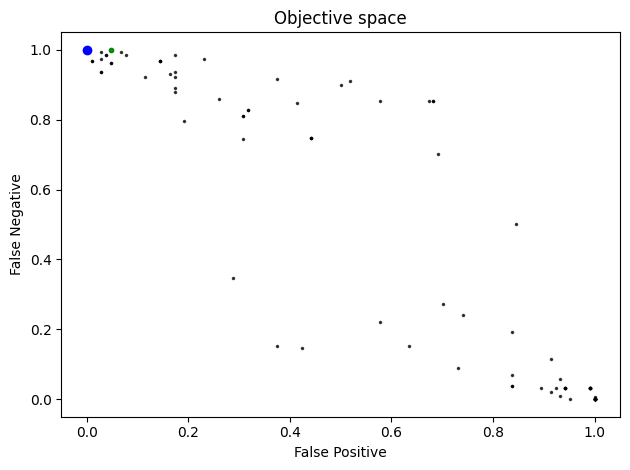

In [ ]:
import matplotlib.pyplot as plt

for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('False Positive');plt.ylabel('False Negative');
plt.title('Objective space');
plt.tight_layout()
plt.show()

In [ ]:
from deap import algorithms, base, creator, tools, gp
import operator
import random
import numpy as np

NGEN = 50
MU = 50
LAMBDA = 100
CXPB = 0.5
MUTPB = 0.2

pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
#replace axis = 0 with distance to (0,0)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

gen	nevals	avg                    	std                    	min    	max    
0  	50    	[0.13153846 0.8878534 ]	[0.29236108 0.29264363]	[0. 0.]	[1. 1.]
1  	72    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
2  	64    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
3  	64    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
4  	70    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
5  	70    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
6  	70    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
7  	68    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
8  	69    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
9  	72    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
10 	70    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
11 	62    	[0. 1.]                	[0. 0.]                	[0. 1.]	[0. 1.]
12 	75    	[0.         0.

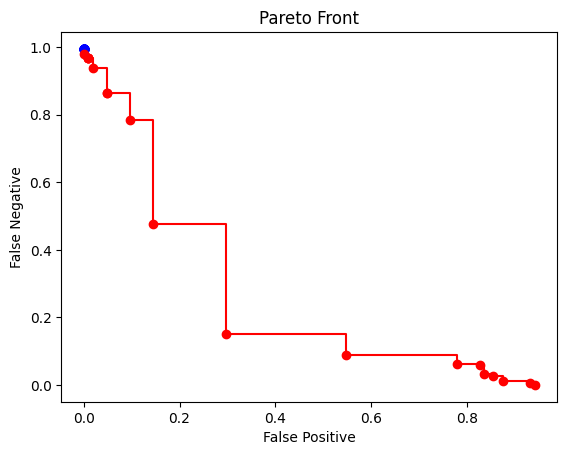

Area Under Curve: 0.2621828433346758


In [ ]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Positive")
plt.ylabel("False Negative")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))


In [ ]:
random.seed(100)
np.random.seed(100)

NN_clf = neural_network.MLPClassifier()
NN_clf.fit(X_train.values, y_train.values)
print(NN_clf.score(X_test.values, y_test.values))

0.8101694915254237


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
def classifier(regressed_values,alpha):
    classified = [1 if val >= alpha else 0 for val in regressed_values]
    return classified

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = y_test.values

y_scores = nn_pipeline.predict_proba(X_test.values)[:, 1]

y_probs = NN_clf.predict_proba(X_test.values)[:, 1]

y_pred = (y_probs >= 0.5).astype(int)


tn, fp, fn, tp = confusion_matrix(y_true, classifier(y_pred,0.5)).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_true, classifier(y_pred,0.5), labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)

Confusion Matrix
[[162  29]
 [ 27  77]]

True Negatives 162
False Positives 29
False Negatives 27
True Positives 77


In [ ]:
def pareto_analysis(y_truth, y_probs):
    alphas = np.arange(0.0, 1.01, 0.01)
    fpr = []
    fnr = []
    for alpha in alphas:
        y_pred = classifier(y_probs, alpha)
        tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
        fpr.append(fp / (fp + tn))
        fnr.append(fn / (fn + tp))
    return fpr, fnr

In [ ]:
def pareto_testing(fpr, fnr):
    ans = 0
    for i in range(1, len(fpr)):
        ans += (fpr[i-1] - fpr[i]) * fnr[i]
    return ans

fpr, fnr = pareto_analysis(y_true, y_probs)
print("Pareto Testing:", pareto_testing(fpr, fnr))

Pareto Testing: 0.14070680628272256


In [ ]:
def NN():
    nn_clf = MLPClassifier(
        hidden_layer_sizes=(50, 20),
        max_iter=500,
        solver="adam",
        random_state=100,
        early_stopping=True,
        n_iter_no_change=10
    )
    nn_clf.fit(X_train.values, y_train.values)
    y_scores = nn_clf.predict_proba(X_test.values)[:, 1]
    y_true   = y_test.values
    return y_scores, y_true

def fulltest(outputs):
    y_scores, y_true = outputs
    fpr, fnr = pareto_analysis(y_true, y_scores)
    return pareto_testing(fpr, fnr)


NN_test = fulltest(NN())
print("NN Pareto test score:", NN_test)




NN Pareto test score: 0.2853906564639548


In [ ]:
from sklearn.metrics import confusion_matrix

y_probs = NN_clf.predict_proba(X_test.values)[:, 1]
y_true = y_test.values

y_pred = classifier(y_probs, 0.5)

tn, fp, fn, tp = confusion_matrix(y_true, classifier(y_pred,0.5)).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_true, classifier(y_pred,0.5), labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)

Confusion Matrix
[[162  29]
 [ 27  77]]

True Negatives 162
False Positives 29
False Negatives 27
True Positives 77


Minimum distance from origin at FPR: 0.18324607329842932 FNR: 0.25 Distance: 0.30996632620220754 alpha = 0.43


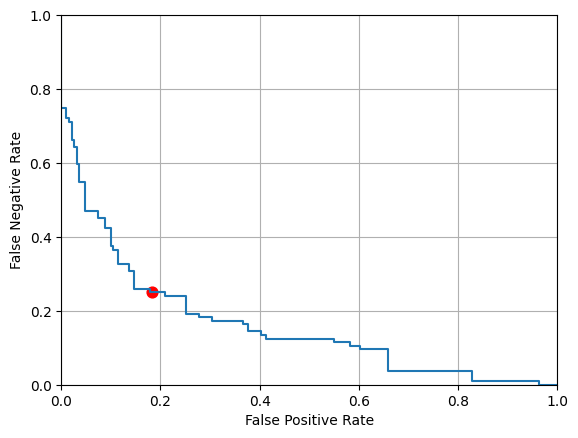

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def pareto_analysis(y_true, scores):
    alphas = np.linspace(0, 1, 101)
    fpr, fnr = [], []
    for a in alphas:
        y_hat = (scores >= a).astype(int)          # threshold PROBABILITIES
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        fpr.append(fp / (fp + tn))
        fnr.append(fn / (fn + tp))
    return np.array(fpr), np.array(fnr)

def pareto_plot(fpr, fnr):
    plt.step(fpr, fnr, where="post")
    idx = np.argmin(fnr**2 + fpr**2)
    plt.scatter(fpr[idx], fnr[idx], c="red", s=60)
    print("Minimum distance from origin at FPR:", fpr[idx],
          "FNR:", fnr[idx],
          "Distance:", np.sqrt(fpr[idx]**2 + fnr[idx]**2),
          "alpha =", idx/100)
    plt.xlabel("False Positive Rate")
    plt.ylabel("False Negative Rate")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.grid(True); plt.show()

fpr, fnr = pareto_analysis(y_true, y_scores)
pareto_plot(fpr, fnr)


In [ ]:
# create confusion matrix plot


cnf_matrix = confusion_matrix(y_truth, classifier(y_pred,0.5))
class_names = ["Did Not Survive", "Survived"]

plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cnf_matrix.max() / 2.

NameError: name 'y_truth' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

model = nn_pipeline if 'nn_pipeline' in globals() else NN_clf

probs = model.predict_proba(X_test.values)[:, 1]
y_true = y_test.values

fpr, tpr, thresh = roc_curve(y_true, probs)
fnr = 1 - tpr

pts = np.c_[fpr, fnr]
keep = np.ones(len(pts), dtype=bool)
for i, (x_i, y_i) in enumerate(pts):
    if not keep[i]:
        continue
    dominated = np.any(((pts[:,0] <= x_i) & (pts[:,1] <= y_i)) & ((pts[:,0] < x_i) | (pts[:,1] < y_i)))
    if dominated:
        keep[i] = False

pareto_fpr = fpr[keep]
pareto_fnr = fnr[keep]
order = np.argsort(pareto_fpr)

idx_05 = np.argmin(np.abs(thresh - 0.5))

plt.figure(figsize=(5,5))
plt.plot(pareto_fpr[order], pareto_fnr[order], '-o', label='Pareto boundary')
plt.scatter(fpr[idx_05], fnr[idx_05], s=60, c='red')

plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.xlim(0,1); plt.ylim(0,1)
plt.title('Neural Net Pareto Boundary (FPR vs FNR)')
plt.legend()
plt.show()


In [ ]:
random.seed(100)
np.random.seed(100)

svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train.values, y_train.values)
print(svm_clf.score(X_test.values, y_test.values))
y_pred = svm_clf.predict(X_test.values)
y_truth = y_test.values

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
class_names=['0', '1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
predictions = NN_clf.predict(test_data.values)

In [ ]:
type(predictions)

In [ ]:
predictions

In [ ]:
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)

In [ ]:
pred_df

In [ ]:
pred_df.to_csv('predictions.csv', header=True, sep=',')

In [ ]:
from sklearn.preprocessing import LabelEncoder

def preprocess(df):
    df = df.copy()

    # Fill missing values
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())

    # Encode categorical features
    df["Sex"] = LabelEncoder().fit_transform(df["Sex"])
    df["Embarked"] = LabelEncoder().fit_transform(df["Embarked"])

    # Drop columns we don’t want
    drop_cols = ["Name", "Ticket", "Cabin"]
    df = df.drop(columns=drop_cols, errors="ignore")

    return df

In [ ]:
import pandas as pd
from google.colab import files

# 1. Load Kaggle test set
kaggle_test = pd.read_csv("test.csv")

# 2. Apply the same preprocessing you used for train/test
X_kaggle_test = preprocess(kaggle_test)

# 3. Get predictions from your trained model (NN_clf or nn_pipeline)
kaggle_preds = NN_clf.predict(X_kaggle_test)

# 4. Create submission DataFrame
submission = pd.DataFrame({
    "PassengerId": kaggle_test["PassengerId"],
    "Survived": kaggle_preds.astype(int)
})

# 5. Save as CSV
submission.to_csv("submission.csv", index=False)

# 6. Download to your computer
files.download("submission.csv")


In [ ]:
from google.colab import files

# Save your submission DataFrame
submission.to_csv("submission.csv", index=False)

# Download to your computer
files.download("submission.csv")